### [N-STARK (Non-STAtionary loads Routing on networKs)](https://github.com/aleable/N-STARK)


**Contributors:**
- Alessandro Lonardi
- Caterina De Bacco

In [1]:
from main import *

!pip install -q nbimporter
import nbimporter
import dashboard_misc

### Initialization

The parameters needed to run **N-STARK** are the following:


- ***Problem construction***

    - ```topol``` = ```"delaunay"``` or ```"real"```: choose which graph topology you want to build, use ```"synth"``` to generate a [Delaunay triangulation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Delaunay.html) of nodes placed randomly in the square $[0,1] \times [0,1]$, ```"real"``` to use the Bordeaux bus network
    
    - ```exec_mode``` = ```"evolution"``` or ```"fourier"```: choose which dynamics you want to run, use ```"evolution"``` to consider time dependent loads, and ```"fourier"``` to use the Fourier coefficients as forcings

    - ```gseed``` (```type=int```): seed for the nodes' coordinates random initialization: $x_v \sim U(0,1)$, $y_v \sim U(0,1)$

    - ```museed``` (```type=int```): seed for the conductivities random initialization $\mu_e(0) \sim U(0,1)$

    - ```massseed``` (```type=int```): seed for the random initialization of the mass loads (more later)

    - ```pflux``` (```type=float```): $0 < \beta < 2$ ($\beta = 2 - \gamma$), regulatory parameter for traffic congestion
   
- ***Forcing construction***

    The construction of the right hand side is different for synthetic and real networks, in particular: 
    
    1. If ```topol``` = ```"delaunay"```, then the input loads are constructed injecting $S_v (t) = 20 A_v \cos(2 \pi m_1 t) +  10 A_v \cos(2 \pi m_2 t) +  5 A_v \cos(2 \pi m_3 t)$, $\, \forall v \in V$, with $A \sim \text{Dirichlet}(\vec{k} = \vec{1}_{|V|}) - 1/|V|$
    
    2. If ```topol``` = ```"real"```, the input loads are constructed as $S_v(t) = \sum_{i \in \{m_1, m_2, m_3\}} A_v^i \cos (2 \pi i t)$, with $A^i = 100/$ ```n_choice``` for ```n_choice``` randomly extracted nodes, and $A^i = -100/(|V|-$ ```n_choice```$)$ for the remaining $|V|-$ ```n_choices``` ones. If $m_1, m_2$ or $m_3$ is equal to $-1$, the amplitudes are set to $0$
    
    The parameters are:
    
    - ```mode1``` (```type=int```): $m_1$

    - ```mode2``` (```type=int```): $m_2$

    - ```mode3``` (```type=int```): $m_3$

    - ```n_choice``` (```type=int```): number of nodes with positive amplitudes forcings 

- ***Dynamics parameters***

    - ```time_step``` (```type=float```): time step for the dynamics with time dependent forcings
    
    - ```time_step_f```  (```type=float```):  time step dynamics with Fourier coefficients
    
    - ```time_meta``` (```type=float```): upped bound time dynamics with time dependent forcings
 
    - ```tot_time``` (```type=int```): upper bound on the number of time steps (safety variable)
    
    - ```relax_linsys``` (```type=float```): relaxation for the weighted Laplacian
    
    - ```tau_cond_dyn``` (```type=float```): threshold for convergence, using the conductivities
     
 
- ***Misc***
    
    - ```VERBOSE``` (```type=bool```)

In [11]:
# Problem construction
topol = "real"
exec_mode = "fourier"
gseed = 0
museed = 0
massseed = 0
pflux = 1.0

# Forcing construction
# IMPORTANT: keep mode1, mode2, mode3 < 10, otherwise change sample frequency in initialization.py
mode1 = 1
mode2 = -1
mode3 = -1
n_choice = 1

# Time dependent loads dynamucs
relax_linsys = 1e-5
time_step = 0.01         # << time_step_f to capture the behavior of the forcings
time_meta = 10
tot_time = 1000

# Dynamics with Fourier coefficients
time_step_f = 0.1          # time step Fourier dynamics
tau_cost_dyn = 1e-5      # threshold convergence cost dynamics

VERBOSE = False

### Running the schemes

In [3]:
nstark_f = NSTARK(exec_mode, topol, gseed, museed, pflux, VERBOSE, relax_linsys,
               tau_cost_dyn, time_step, time_step_f, time_meta, tot_time,
               massseed, mode1, mode2, mode3, n_choice)

Now, you can run **N-STARK**. The execution is made of three steps:

1. construction of the problem setup, i.e. graph topology and forcings
2. execution of the dynamics
3. serialization of the outputs

In [4]:
nstark_f.ot_setup() # step 1
nstark_f.dyn_exec() # step 2
tdens_stack_f, tdens_opt_f, cost_stack_f = nstark_f.export_fourier() # step 3

* graph topology construction
* running [fourier dynamics]
	dynamics fourier converged [stopping criteria]
* serialize Fourier dynamics


To run **N-STARK** considering the time dependent loads dynamics, use:

In [5]:
exec_mode = "evolution"
VERBOSE = False

In [6]:
nstark = NSTARK(exec_mode, topol, gseed, museed, pflux, VERBOSE, relax_linsys,
               tau_cost_dyn, time_step, time_step_f, time_meta, tot_time,
               massseed, mode1, mode2, mode3, n_choice)

In [7]:
graph, length, C, forcing = nstark.ot_setup() # step 1, we also export the inputs so we can plot the results 
nstark.dyn_exec() # step 2
tdens_stack, flux_stack, cost_stack = nstark.export_evolution() # step 3

* graph topology construction
* running [long run dynamics]
	dynamics time dependent loads converged [oscillating state]
* serialize time dependent loads dynamics


### Plot the results:

- Time evolution of the conductivities $\bar{\mu}$ and $\mu$ in the two intervals $t < t_\mathrm{STAB}$ and $t \gg t_\mathrm{STAB}$
- Evolution of the functionals $\bar{\mathcal{L}}_\gamma$ and $\langle \mathcal{L}_\gamma \rangle_T$ in time
- Optimal transport network visualization. Nodes' sizes are proportional to the maximum value attained by the loads—in a given node—over a period. The width and the color of the edges are set with $\bar{\mu}^\infty$


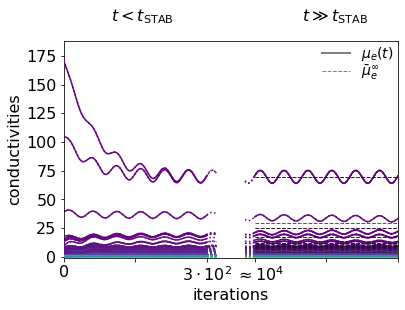

In [8]:
dashboard_misc.plot_conductivities(graph,tdens_stack, tdens_stack_f, tdens_opt_f, time_step)

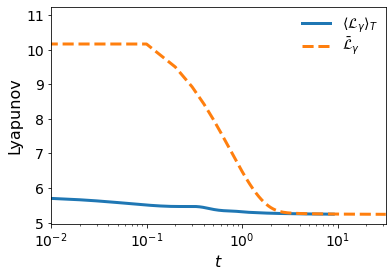

In [9]:
dashboard_misc.plot_functionals(tdens_stack_f, cost_stack_f, tdens_stack, flux_stack,
                                length, time_step, time_step_f, pflux)

Loading geospatial data from OpenStreetMap, this may take a while...


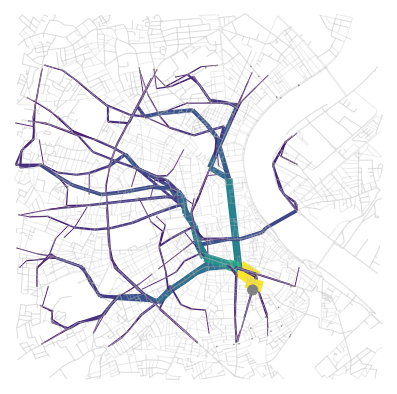

In [10]:
if topol == "real": dashboard_misc.plot_network(graph, tdens_stack, tdens_opt_f, forcing)